<a href="https://www.kaggle.com/code/averma111/emission-numpyrmsle-catboost-lgbm-xgboost?scriptVersionId=138952508" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [108]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import warnings
warnings.filterwarnings('ignore')
import plotly.express as px
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import mutual_info_regression
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import  CatBoostRegressor, Pool
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import RepeatedKFold
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_regression
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/playground-series-s3e20/sample_submission.csv
/kaggle/input/playground-series-s3e20/train.csv
/kaggle/input/playground-series-s3e20/test.csv


In [109]:
ROOT_PATH = '/kaggle/input/playground-series-s3e20'
train = pd.read_csv(ROOT_PATH+'/train.csv')
test = pd.read_csv(ROOT_PATH+'/test.csv')


In [110]:
## https://www.kaggle.com/code/arjanso/reducing-dataframe-memory-size-by-65
def reduce_memory_usage(df):
    
    start_mem = df.memory_usage().sum() / 1024 ** 2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype.name
        if ((col_type != 'datetime64[ns]') & (col_type != 'category')):
            if (col_type != 'object'):
                c_min = df[col].min()
                c_max = df[col].max()

                if str(col_type)[:3] == 'int':
                    if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int8)
                    elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int16)
                    elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32)
                    elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                        df[col] = df[col].astype(np.int64)

                else:
                    if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                        df[col] = df[col].astype(np.float16)
                    elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                        df[col] = df[col].astype(np.float32)
                    else:
                        pass
            else:
                df[col] = df[col].astype('category')
    mem_usg = df.memory_usage().sum() / 1024 ** 2 
    print("Memory usage became: ",mem_usg," MB")
    
    return df

In [111]:
def NumPyRMSLE(y_true: list, y_pred: list) -> float:
    n = len(y_true)
    rmsle = np.sqrt(np.mean(np.square(np.log1p(y_pred) - np.log1p(y_true))))
    return rmsle

In [112]:
def summary(text, df):
    print(f'{text} shape: {df.shape}')
    summ = pd.DataFrame(df.dtypes, columns=['dtypes'])
    summ['null'] = df.isnull().sum()
    summ['unique'] = df.nunique()
    summ['min'] = df.min()
    summ['median'] = df.median()
    summ['max'] = df.max()
    summ['mean'] = df.mean()
    summ['std'] = df.std()
    return summ

In [113]:
summary('train',train)

train shape: (79023, 76)


,dtypes,null,unique,min,median,max,mean,std
ID_LAT_LON_YEAR_WEEK,object,0,79023,ID_-0.510_29.290_2019_00,NaN,ID_-3.299_30.301_2021_52,NaN,NaN
latitude,float64,0,452,-3.299,-1.882000,-0.51,-1.891072,0.694522
longitude,float64,0,453,28.228,29.883000,31.532,29.880155,0.810375
year,int64,0,3,2019,2020.000000,2021,2020.000000,0.816502
week_no,int64,0,53,0,26.000000,52,26.000000,15.297155
...,...,...,...,...,...,...,...,...
Cloud_sensor_azimuth_angle,float64,484,78538,-102.739731,-12.673914,78.223037,-10.784832,30.374462
Cloud_sensor_zenith_angle,float64,484,78539,2.998873,41.119630,65.951248,40.436976,6.428216
Cloud_solar_azimuth_angle,float64,484,78539,-153.464211,-84.644352,-22.65317,-86.800583,37.837269
Cloud_solar_zenith_angle,float64,484,78539,10.818288,28.333630,42.060436,27.925981,4.403835


In [114]:
def removenan(df,column):
        df[column].fillna(df[column].mean(), inplace=True)
        return df

In [115]:
for cols in train.columns:
    if train[cols].isnull().sum()>0:
        train=removenan(train,cols)

In [116]:
summary('train',train)

train shape: (79023, 76)


,dtypes,null,unique,min,median,max,mean,std
ID_LAT_LON_YEAR_WEEK,object,0,79023,ID_-0.510_29.290_2019_00,NaN,ID_-3.299_30.301_2021_52,NaN,NaN
latitude,float64,0,452,-3.299,-1.882000,-0.51,-1.891072,0.694522
longitude,float64,0,453,28.228,29.883000,31.532,29.880155,0.810375
year,int64,0,3,2019,2020.000000,2021,2020.000000,0.816502
week_no,int64,0,53,0,26.000000,52,26.000000,15.297155
...,...,...,...,...,...,...,...,...
Cloud_sensor_azimuth_angle,float64,0,78539,-102.739731,-12.653263,78.223037,-10.784832,30.281299
Cloud_sensor_zenith_angle,float64,0,78540,2.998873,41.073490,65.951248,40.436976,6.408500
Cloud_solar_azimuth_angle,float64,0,78540,-153.464211,-85.397329,-22.65317,-86.800583,37.721217
Cloud_solar_zenith_angle,float64,0,78540,10.818288,28.289776,42.060436,27.925981,4.390328


In [117]:
X = train.copy()
X = X.loc[:, X.columns!='ID_LAT_LON_YEAR_WEEK']
y = X['emission']
X.drop(columns=['emission'],axis=1,inplace=True)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=False)
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(63218, 74) (15805, 74) (63218,) (15805,)


In [118]:
# feature selection
def select_features(X_train, y_train, X_val):
    fs = SelectKBest(score_func=f_regression, k='all')
    fs.fit(X_train, y_train)
    X_train_fs = fs.transform(X_train)
    X_val_fs = fs.transform(X_val)
    return X_train_fs, X_val_fs, fs

In [119]:
X_train_fs, X_val_fs, fs = select_features(X_train, y_train, X_val)

In [120]:
# what are scores for the features
for i in range(len(fs.scores_)):
    print('Feature %d: %f' % (i, fs.scores_[i]))


Feature 0: 668.148739
Feature 1: 424.706642
Feature 2: 11.413752
Feature 3: 2.724367
Feature 4: 33.173012
Feature 5: 0.063980
Feature 6: 41.760483
Feature 7: 2.460762
Feature 8: 32.207913
Feature 9: 0.969685
Feature 10: 46.859414
Feature 11: 0.047880
Feature 12: 41.060678
Feature 13: 129.004026
Feature 14: 196.308608
Feature 15: 37.423542
Feature 16: 285.984294
Feature 17: 0.090181
Feature 18: 0.000239
Feature 19: 40.572218
Feature 20: 21.749510
Feature 21: 2.580969
Feature 22: 0.605019
Feature 23: 21.515131
Feature 24: 8.902298
Feature 25: 0.400873
Feature 26: 10.844087
Feature 27: 21.361177
Feature 28: 358.943799
Feature 29: 37.516296
Feature 30: 1.304130
Feature 31: 48.427377
Feature 32: 2.616637
Feature 33: 81.401471
Feature 34: 117.409544
Feature 35: 38.442337
Feature 36: 0.030642
Feature 37: 0.640026
Feature 38: 46.810397
Feature 39: 1.141660
Feature 40: 25.916760
Feature 41: 0.085670
Feature 42: 547.132446
Feature 43: 4.581983
Feature 44: 6.402545
Feature 45: 34.137704
Feature 4

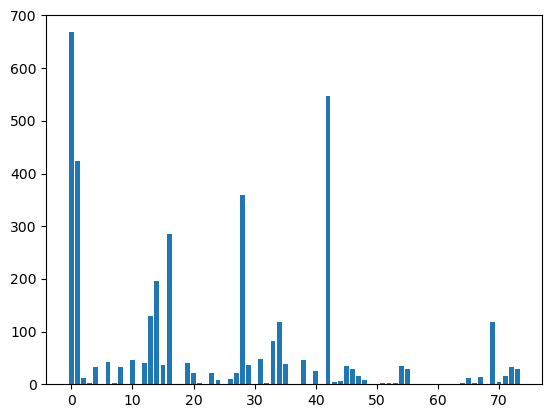

In [121]:
plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
plt.show()

In [122]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from math import sqrt

# fit the model
model = LinearRegression()
model.fit(X_train, y_train)
yhat = model.predict(X_val)
rmse = mean_squared_error(y_val, yhat,squared=False)
print('RMSE: %.3f' % rmse)

RMSE: 103.372


In [123]:
def select_features_mutual(X_train, y_train, X_val):
    fs = SelectKBest(score_func=mutual_info_regression, k='all')
    fs.fit(X_train, y_train)
    X_train_fs = fs.transform(X_train)
    X_val_fs = fs.transform(X_val)
    return X_train_fs, X_val_fs, fs

In [124]:
X_train_fs, X_val_fs, fs = select_features_mutual(X_train, y_train, X_val)

In [125]:
# what are scores for the features
for i in range(len(fs.scores_)):
    print('Feature %d: %f' % (i, fs.scores_[i]))


Feature 0: 2.309599
Feature 1: 2.351581
Feature 2: 0.015668
Feature 3: 0.011691
Feature 4: 0.014243
Feature 5: 0.013356
Feature 6: 0.012134
Feature 7: 0.009632
Feature 8: 0.034827
Feature 9: 0.029621
Feature 10: 0.023504
Feature 11: 0.010056
Feature 12: 0.020507
Feature 13: 0.012794
Feature 14: 0.024690
Feature 15: 0.009055
Feature 16: 0.010739
Feature 17: 0.023229
Feature 18: 0.024023
Feature 19: 0.017488
Feature 20: 0.008075
Feature 21: 0.012482
Feature 22: 0.010229
Feature 23: 0.018090
Feature 24: 0.008101
Feature 25: 0.099180
Feature 26: 0.008480
Feature 27: 0.007633
Feature 28: 0.017735
Feature 29: 0.030138
Feature 30: 0.026011
Feature 31: 0.019007
Feature 32: 0.008560
Feature 33: 0.013380
Feature 34: 0.028288
Feature 35: 0.007369
Feature 36: 0.012118
Feature 37: 0.013087
Feature 38: 0.018400
Feature 39: 0.039535
Feature 40: 0.037509
Feature 41: 0.015897
Feature 42: 0.032205
Feature 43: 0.057641
Feature 44: 0.035819
Feature 45: 0.033879
Feature 46: 0.021803
Feature 47: 0.018215
Fe

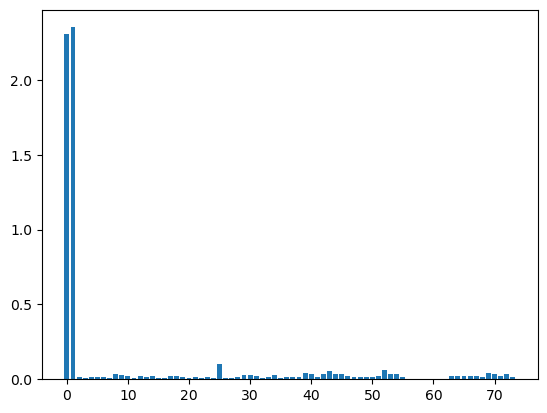

In [126]:
plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
plt.show()

In [127]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from math import sqrt

# fit the model
model = LinearRegression()
model.fit(X_train, y_train)
yhat = model.predict(X_val)
rmse = mean_squared_error(y_val, yhat,squared=False)
print('RMSE: %.3f' % rmse)

RMSE: 103.372


In [ ]:
from sklearn.model_selection import cross_val_score
num_features = [i for i in range(X.shape[1]-19, X.shape[1]+1)]
results = []
for k in num_features:
    model = LinearRegression()
    fs = SelectKBest(score_func=mutual_info_regression, k=k)
    pipeline = Pipeline(steps=[('sel',fs), ('lr', model)])
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(pipeline, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
    results.append(scores)
    print('>%d %.3f (%.3f)' % (k, mean(scores), std(scores)))


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [ ]:
plt.boxplot(results, labels=num_features, showmeans=True)
plt.show()

In [ ]:
def evaluation(model_str, y_pred, y_pred_train):
    results = {
        'model': model_str,
        'rmsle score': NumPyRMSLE(y_train,y_pred_train) # faster than sklearn rmsle
    }
    return results

In [ ]:
model=CatBoostRegressor(iterations=300, depth=6, learning_rate=0.1, 
loss_function='RMSE',
         rsm = 0.95, 
         border_count = 64, 
         l2_leaf_reg= 3.5, 
         one_hot_max_size=30, 
         use_best_model = True,
         verbose=False,
         random_seed = 502)
model.fit(X_train, y_train,
     eval_set=(X_val, y_val),   
     verbose = False,
     plot=True)

In [ ]:
y_pred = model.predict(X_val)
y_pred_train = model.predict(X_train)
result = evaluation(model, y_pred, y_pred_train)
result_list.append(result)
df_eval = pd.DataFrame(result_list)
df_eval